In [1]:
######## Packages ########
import numpy as np 
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML 

## 4.3.4
崩壊型ギブスサンプリングを用いて，ポアソン混合モデルの事後分布から潜在変数をサンプリングする．
- 参考
    - https://www.anarchive-beta.com/entry/2020/04/26/234420

In [2]:
#################### param (truth) ####################
lambda_truth = np.array([20, 55])
pi_truth = np.array([0.4, 0.6])
#######################################################

In [3]:
#################### Param (observed) ####################
N = 100                 # the number of observed data
K = len(lambda_truth)   # the number of clusters
##########################################################


#################### Clusters (Eq.(4.2)) ####################
s_nk = stats.multinomial(n=1, p=pi_truth).rvs(size=N)
#############################################################


#################### Observed data (Eq.(4.28)) ####################
def generate_observed_data(lmd, s, K):
    dt = 1
    for k in range(K):
        val = stats.poisson(mu = lmd[k]).rvs()
        dt = dt*val**s[k]
    return dt

x_n = []
for n in range(N):
    x_n.append(generate_observed_data(lmd=lambda_truth, s=s_nk[n], K=K))
x_n = np.array(x_n)
###################################################################

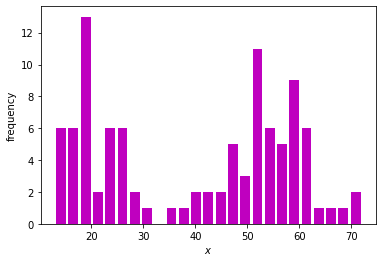

In [4]:
#################### Plot observed data ####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel("frequency")
ax.hist(x_n, bins=25, rwidth=0.8, color='m')
plt.show()
############################################################

In [5]:
#################### Param (estimation) ####################
maxiter = 50                # the number of iteration
a = 1; b = 1                # hyper parameter for gamma distribution
alpha = np.array([2, 2])  # hyper parameter for Dirichlet distribution
############################################################

#################### Initial value of hidden variable ####################
S_0 = []
for n in range(N):
    rand_p = stats.uniform().rvs()
    if rand_p <= 0.5:
        eta_n = np.array([1, 0])
    else:
        eta_n = np.array([0, 1])
    s_n = stats.multinomial(n=1, p=eta_n).rvs()[0]
    S_0.append(s_n)
S_0 = np.array(S_0)
##########################################################################


In [6]:
#################### list ####################
def make_list(n):
    return [[] for i in range(n)]
##############################################

In [7]:
#################### calculate parameters (Eq. (4.45), (4.55)) ####################
def calculate_param(S, x, alpha, a, b):
    hat_alpha = []; hat_a = []; hat_b = []
    for k in range(len(S.T)):
        hat_alpha_k = np.sum(S.T[k]) + alpha[k]; hat_alpha.append(hat_alpha_k)
        hat_a_k = np.sum(S.T[k] * x) + a; hat_a.append(hat_a_k)
        hat_b_k = np.sum(S.T[k]) + b; hat_b.append(hat_b_k)
    hat_alpha = np.array(hat_alpha); hat_a = np.array(hat_a); hat_b = np.array(hat_b)
    return hat_alpha, hat_a, hat_b
##############################################################

#################### test ####################
hat_alpha, hat_a, hat_b = calculate_param(S=S_0, x=x_n, alpha=alpha, a=a, b=b)
print(hat_alpha)
print(hat_a)
print(hat_b)
##############################################

[52 52]
[2089 1912]
[51 51]


In [8]:
#################### Erase statistics related to nth data ####################
def erase_param(hat_alpha, hat_a, hat_b, sn, xn):
    hat_alpha_mn = []; hat_a_mn = []; hat_b_mn = []
    for k in range(len(sn)):
        hat_alpha_mn_k = hat_alpha[k] - sn[k]; hat_alpha_mn.append(hat_alpha_mn_k)
        hat_a_mn_k = hat_a[k] - sn[k]*xn; hat_a_mn.append(hat_a_mn_k)
        hat_b_mn_k = hat_b[k] - sn[k]; hat_b_mn.append(hat_b_mn_k)
    hat_alpha_mn = np.array(hat_alpha_mn); hat_a_mn = np.array(hat_a_mn); hat_b_mn = np.array(hat_b_mn)
    return hat_alpha_mn, hat_a_mn, hat_b_mn 
############################################################

#################### test ####################
hat_alpha_mn, hat_a_mn, hat_b_mn = erase_param(hat_alpha=hat_alpha, hat_a=hat_a, hat_b=hat_b, sn=S_0[1], xn=x_n[1])
print(hat_alpha_mn)
print(hat_a_mn)
print(hat_b_mn)
##############################################

[52 51]
[2089 1890]
[51 50]


In [9]:
#################### Add statistics related to nth data ####################
def add_param(hat_alpha_mn, hat_a_mn, hat_b_mn, sn, xn):
    new_hat_alpha = []; new_hat_a = []; new_hat_b = []
    for k in range(len(sn)):
        new_hat_alpha_k = hat_alpha_mn[k] + sn[k]; new_hat_alpha.append(new_hat_alpha_k)
        new_hat_a_k = hat_a_mn[k] + sn[k]*xn; new_hat_a.append(new_hat_a_k)
        new_hat_b_k = hat_b_mn[k] + sn[k]; new_hat_b.append(new_hat_b_k)
    new_hat_alpha = np.array(new_hat_alpha); new_hat_a = np.array(new_hat_a); new_hat_b = np.array(new_hat_b)
    return new_hat_alpha, new_hat_a, new_hat_b 
############################################################################

#################### test ####################
new_hat_alpha, new_hat_a, new_hat_b = add_param(hat_alpha_mn=hat_alpha_mn, hat_a_mn=hat_a_mn, hat_b_mn=hat_b_mn, sn=S_0[1], xn=x_n[1])
print(new_hat_alpha)
print(new_hat_a)
print(new_hat_b)
##############################################

[52 52]
[2089 1912]
[51 51]


In [10]:
#################### Negative binomial dist (Eq.(3.43)) ####################
def NB(x, r, p):
    val = ((1 - p)**r)*p**x 
    pos = x*special.beta(x, r)
    return val/pos
############################################################################

#################### Calculate xi (Eq.(4.81)) ####################
def calculate_xi(hat_alpha_mn, hat_a_mn, hat_b_mn, xn):
    xi_tmp = []
    for k in range(len(hat_alpha_mn)):
        xi_tmp_k = NB(x=xn, r=hat_a_mn[k], p=1/(hat_b_mn[k] + 1))*hat_alpha_mn[k]; xi_tmp.append(xi_tmp_k)
    xi_mn = np.array(xi_tmp) / sum(xi_tmp)
    return xi_mn
##################################################################

#################### test ####################
xi_test = calculate_xi(hat_alpha_mn=hat_alpha_mn, hat_a_mn=hat_a_mn, hat_b_mn=hat_b_mn, xn=x_n[1])
print(xi_test)
##############################################
    

[0.2051577 0.7948423]


In [11]:
#################### Collapsed Gibbs sampling ####################
def collapsed_Gibbs_poisson(maxiter, N, K, S_init, x, a, b, alpha):
    #################### Initialization ####################
    S_list = [S_0]
    hat_alpha_init, hat_a_init, hat_b_init = calculate_param(S=S_init, x=x, alpha=alpha, a=a, b=b)
    hat_a_list = [hat_a_init]; hat_b_list = [hat_b_init]; hat_alpha_list = [hat_alpha_init]
    ########################################################

    #################### Loop process ####################
    for i in range(maxiter):
        S_current = S_list[-1]; S_new = []
        for n in range(N):
            hat_alpha = hat_alpha_list[-1]; hat_a = hat_a_list[-1]; hat_b = hat_b_list[-1]
            #################### Erase ####################
            hat_alpha_mn, hat_a_mn, hat_b_mn = erase_param(hat_alpha=hat_alpha, hat_a=hat_a, hat_b=hat_b, sn=S_current[n], xn=x[n])
            ###############################################

            #################### Calculate xi ####################
            xi_mn = calculate_xi(hat_alpha_mn=hat_alpha_mn, hat_a_mn = hat_a_mn, hat_b_mn=hat_b_mn, xn=x[n])
            ######################################################

            #################### Sample s_n (Eq.(4.66)) ####################
            s_n = stats.multinomial(n=1, p=xi_mn).rvs()[0]
            S_new.append(s_n)
            ################################################################

            #################### Add ####################
            new_hat_alpha, new_hat_a, new_hat_b = add_param(hat_alpha_mn=hat_alpha_mn, hat_a_mn=hat_a_mn, hat_b_mn=hat_b_mn, sn=s_n, xn=x[n])
            hat_alpha_list.append(new_hat_alpha); hat_a_list.append(new_hat_a); hat_b_list.append(new_hat_b)
            #############################################

        #################### Add sample to the list ####################
        S_new = np.array(S_new); S_list.append(S_new)
        ################################################################
    #########################################################
    hat_a_list = np.array(hat_a_list); hat_b_list = np.array(hat_b_list); hat_alpha_list = np.array(hat_alpha_list)
    return S_list, hat_a_list, hat_b_list, hat_alpha_list
###################################################################


In [12]:
#################### execute collapsed Gibbs sampling ####################
S_sample, hat_a_sample, hat_b_sample, hat_alpha_sample = collapsed_Gibbs_poisson(maxiter=maxiter, N=N, K=K, S_init=S_0, x=x_n, a=a, b=b, alpha=alpha)
##########################################################################

MovieWriter imagemagick unavailable; using Pillow instead.


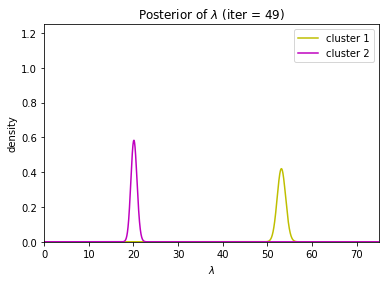

In [13]:
#  post
z1 = np.linspace(0, 75, 7501)
## lambda
lambda_pdf_post = make_list(K)
for i in range(len(hat_a_sample)):
    for k in range(K):
        cluster_k = stats.gamma(a=hat_a_sample[i][k], scale=1/hat_b_sample[i][k]).pdf(z1)
        lambda_pdf_post[k].append(cluster_k)

### plot lambda
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_lambda(frame):
    ax.clear()
    ax.set_xlabel(r"$\lambda$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\lambda$ " + "(iter = {})".format(int((frame-1)/N)))
    ax.set_xlim([0, 75]); ax.set_ylim([0, 1.25])
    ### plot pdf ###
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z1, lambda_pdf_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_lambda, frames=range(1, len(hat_a_sample), N), interval=200)
ani.save("4.3.4_posterior_lambda.gif", writer="imagemagick")
HTML(ani.to_jshtml())


MovieWriter imagemagick unavailable; using Pillow instead.


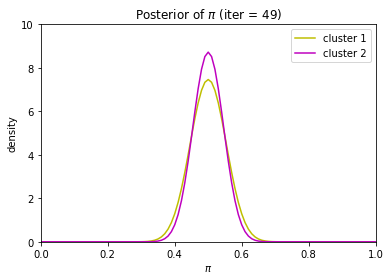

In [14]:
## pi (Dir -> beta)
z2 = np.linspace(0, 1, 101)
pi_post = make_list(K); K_list = list(range(K))
for i in range(len(hat_a_sample)):
    for k in K_list:
        key = list(set(K_list) - {k})[0]
        pi = stats.beta(a=hat_alpha_sample[i][key], b=hat_alpha_sample[i][key]).pdf(z2)
        pi_post[k].append(pi)

### post pi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_pi(frame):
    ax.clear()
    ax.set_xlabel(r"$\pi$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\pi$ " + "(iter = {})".format(int((frame-1)/N)))
    ax.set_xlim([0, 1]); ax.set_ylim([0, 10])
    ### plot pdf
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z2, pi_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_pi, frames=range(1, len(hat_a_sample), N), interval=200)
ani.save("4.3.4_posterior_pi.gif", writer="imagemagick")
HTML(ani.to_jshtml())